# PeakAnalyzer
#### by Jan A. Meissner

Set paths for your script and the resource folder. The folder should contain all the spectral .txt files (for example: resources/CW_16_TE2A_20231031_Absorbance_12-47-13-326.txt)

In [1]:
import pandas as pd
from os import path
import os
#set current directory and directory to resources
current_directory = os.getcwd()
resource_path = os.path.join(current_directory, 'resources')
figure_path = os.path.join(current_directory, 'figures')
files_path = os.path.join(current_directory, 'files')
#create folders if they do not exist
if not os.path.exists(resource_path):
    os.makedirs(resource_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
if not os.path.exists(files_path):
    os.makedirs(files_path)

Load all data in the resource folder to a pandas object

In [2]:
files = [f for f in os.listdir(resource_path) if path.isfile(path.join(resource_path, f))]
dataset = {}
for file in files:
    file_path = os.path.join(resource_path, file)
    data = None
    data = pd.read_csv(
        file_path, 
        sep='\t',          
        decimal=',',         
        skiprows=13           
    )
        # If the data has more than one column, assign column names
    if data.shape[1] > 1:
        data.columns = ["wavelength", "intensity"]
        dataset[file] = data
    else:
        print(f"Error: Only one column found in file {file}")




#### Display graph 

Fit a Lorentz cureve

r^2 error: 0.9975038508256835
Peak position: 614.8520627241826
Peak width (FWHM): 21.509410813789636
Peak intensity: 0.1833620919196554


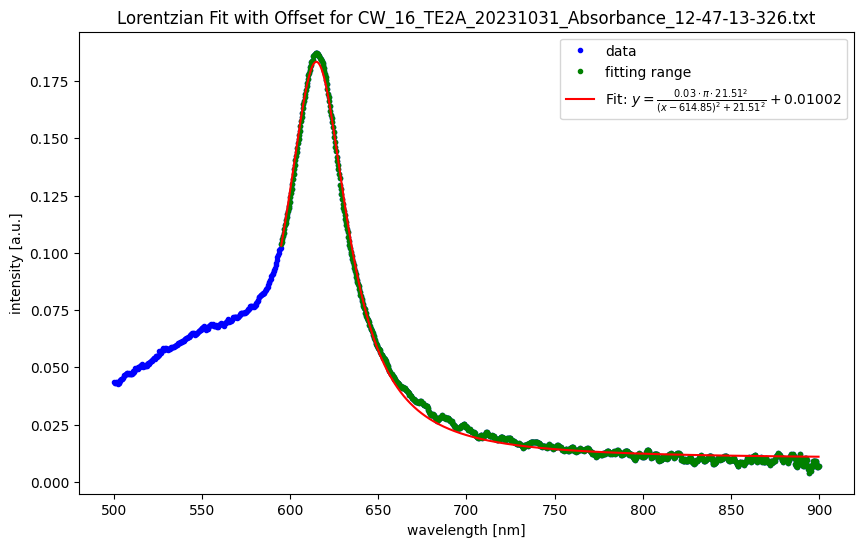

results for CW_16_TE2A_20231031_Absorbance_12-47-13-326.txt written to results.csv


In [4]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the Lorentzian function with an offset 'y0'
def lorentzian_with_offset(x, x0, a, gamma, y0):
    return y0 + (2 * a * np.pi) * (gamma**2 / ((x - x0)**2 + gamma**2))

# Loop through each file in the dataset
for file, data in dataset.items():
    # Filter the DataFrame for the desired wavelength range
    filtered_data = data[(data['wavelength'] > 500) & (data['wavelength'] < 950)]
    
    # Find the index of the row with the maximum intensity within the filtered range
    peak_index = filtered_data['intensity'].idxmax()
    
    # Retrieve the peak position using the peak index
    peak_position = filtered_data.loc[peak_index, 'wavelength']
    
    # Further refine the filtered data to focus on the peak
    filtered_data = filtered_data[(filtered_data['wavelength'] > peak_position - 20) & (filtered_data['wavelength'] < 900)]
    
    # Extract the wavelength and intensity from the filtered data
    x_data = filtered_data['wavelength']
    y_data = filtered_data['intensity']
    
    # Estimate initial parameters for the Lorentzian fit with offset
    x0_initial = peak_position  # Use the peak position found earlier
    a_initial = y_data.max()  # Peak amplitude
    gamma_initial = (x_data.max() - x_data.min()) / 20  # Rough estimate for gamma (HWHM)
    y0_initial = y_data.min()  # Initial estimate for y-offset

    # Bounds for the parameters: lower bounds are 0 for a and gamma, could be negative for y0 if applicable
    # Adjust the bounds based on your data and the expected parameter ranges
    bounds = ([np.min(x_data), 0, 0, -np.inf], [np.max(x_data), np.inf, np.inf, np.inf])

    # Perform the Lorentzian fit with bounds
    popt, pcov = curve_fit(lorentzian_with_offset, x_data, y_data, p0=[x0_initial, a_initial, gamma_initial, y0_initial], bounds=bounds)
    #calculate r^2 error
    residuals = y_data - lorentzian_with_offset(x_data, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data-np.mean(y_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"r^2 error: {r_squared}")
    #print peakposition, peak intensity, peak width (FWHM) and Absorbanz bei 400 nm
    print(f"Peak position: {popt[0]}")
    print(f"Peak width (FWHM): {popt[2]}")
    peak_intensity = lorentzian_with_offset(popt[0], *popt)
    print(f"Peak intensity: {peak_intensity}")
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(data['wavelength'][(data['wavelength'] > 500) & (data['wavelength'] < 900)], data['intensity'][(data['wavelength'] > 500) & (data['wavelength'] < 900)], 'b.', label='data')  # Original data
    plt.plot(x_data, y_data, 'g.', label='fitting range')  # Fitting range

    # Plot the fit
    x_fit = np.linspace(x_data.min(), x_data.max(), 1000)
    y_fit = lorentzian_with_offset(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r-', label=r'Fit: $y = \frac{{%.2f \cdot \pi \cdot %.2f^2}}{{(x - %.2f)^2 + %.2f^2}} + %.5f$' % (popt[1], popt[2], popt[0], popt[2], popt[3]))
    plt.xlabel('wavelength [nm]')
    plt.ylabel('intensity [a.u.]')
    plt.title(f'Lorentzian Fit with Offset for {file}')
    plt.legend()
    plt.savefig(f"{figure_path}/{file}_fit.png", dpi=600)
    plt.show() #Auskommentieren bei vielen Dateien, nur zum anschauen gedacht
    if not os.path.exists(f"{files_path}/results.csv"):
        with open(f"{files_path}/results.csv", "w") as f:
            f.write("Filename    Peakposition    Peakintensity    FWHM    Absorbanz_400nm\n")
    with open(f"{files_path}/results.csv", "a") as f:
        f.write(f"{file}    {popt[0]}  {peak_intensity} {popt[2]}   {popt[3]}\n")
        print(f"results for {file} written to results.csv")
    #plt.show() #Auskommentieren bei vielen Dateien, nur zum anschauen gedacht

Die Bilder werden in den Ordner figures gespeichert mit dem gleichen Namen wie die .txt Datei nur mit .png als Endung.